In [1]:
import os 
import mne 
import numpy as np 

asmr_files = os.listdir("/home/s.dharia-ra/Shyamal/ASMR_NEW/statstical_analysis/asmr_epochs_test")
print(asmr_files)
control_files = os.listdir("/home/s.dharia-ra/Shyamal/ASMR_NEW/statstical_analysis/control_epochs_test")
print(control_files)

asmr_closed = []
asmr_open = []

control_closed = []
control_open = []

for file in asmr_files:
    epochs = mne.read_epochs("/home/s.dharia-ra/Shyamal/ASMR_NEW/statstical_analysis/asmr_epochs/" + file, verbose=0)
    # epochs.drop_channels(["HOEG", "VEOG"])
    asmr_closed.append(epochs["Closed Eyes"].compute_psd().get_data())
    # print(epochs["Closed Eyes"].compute_psd().get_data().mean(axis=0).shape)
    asmr_open.append(epochs["Open Eyes"].compute_psd().get_data())

for file in control_files:

    epochs = mne.read_epochs("/home/s.dharia-ra/Shyamal/ASMR_NEW/statstical_analysis/control_epochs/" + file, verbose=0)
    # epochs.drop_channels(["HOEG", "VEOG"])

    control_closed.append(epochs["Closed Eyes"].compute_psd().get_data())
    
    control_open.append(epochs["Open Eyes"].compute_psd().get_data())


N = 50
asmr_closed = np.array(asmr_closed)
asmr_closed = asmr_closed[:N]
asmr_closed = asmr_closed.reshape(asmr_closed.shape[0] * asmr_closed.shape[1], asmr_closed.shape[2], asmr_closed.shape[3])
asmr_open = np.array(asmr_open)
asmr_open = asmr_open[:N]
asmr_open = asmr_open.reshape(asmr_open.shape[0] * asmr_open.shape[1], asmr_open.shape[2], asmr_open.shape[3])

control_closed = np.array(control_closed)
control_closed = control_closed[:N]
control_closed = control_closed.reshape(control_closed.shape[0] * control_closed.shape[1], control_closed.shape[2], control_closed.shape[3])
control_open = np.array(control_open)
control_open = control_open[:N]
control_open = control_open.reshape(control_open.shape[0] * control_open.shape[1], control_open.shape[2], control_open.shape[3])




print(asmr_closed.shape, asmr_open.shape)
print(control_closed.shape, control_open.shape)

['16-epochs-epo.fif', '8-epochs-epo.fif', '10-epochs-epo.fif', '1-epochs-epo.fif', '11-epochs-epo.fif', '9-epochs-epo.fif', '14-epochs-epo.fif', '12-epochs-epo.fif', '13-epochs-epo.fif', '2-epochs-epo.fif', '6-epochs-epo.fif', '7-epochs-epo.fif', '15-epochs-epo.fif', '5-epochs-epo.fif', '3-epochs-epo.fif', '4-epochs-epo.fif']
['8-epochs-epo.fif', '10-epochs-epo.fif', '1-epochs-epo.fif', '11-epochs-epo.fif', '9-epochs-epo.fif', '14-epochs-epo.fif', '12-epochs-epo.fif', '13-epochs-epo.fif', '2-epochs-epo.fif', '6-epochs-epo.fif', '7-epochs-epo.fif', '15-epochs-epo.fif', '5-epochs-epo.fif', '3-epochs-epo.fif', '4-epochs-epo.fif']
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows

# DE

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests


ch_names = epochs.ch_names

occipital_channels_indices = [i for i, ch in enumerate(ch_names) if ch.startswith("O")]
parietal_channels_indices = [i for i, ch in enumerate(ch_names) if ch.startswith("P")]
temporal_channels_indices = [i for i, ch in enumerate(ch_names) if ch.startswith("T")]
frontal_channels_indices = [i for i, ch in enumerate(ch_names) if ch.startswith("F")]
central_channels_indices = [i for i, ch in enumerate(ch_names) if ch.startswith("C")]


# Use a nice ggplot style
plt.style.use('ggplot')

# Create the plots directory if it doesn't exist
os.makedirs("plots", exist_ok=True)

# Example frequency vector (assuming asmr_closed.shape[2] is the number of frequency bins)
fs = 250
n_freqs = asmr_closed.shape[2]
freqs = np.linspace(0, fs, n_freqs)

# Define frequency bands
freq_bands = {
    "Delta": (1, 4),
    "Theta": (4, 8),
    "Alpha": (8, 12),
    "Beta":  (12, 30),
    "Gamma": (30, 45)
}

# Regions and channel indices (from your previous code)
regions = ["Occipital", "Parietal", "Temporal", "Frontal", "Central"]
channel_indices = [
    occipital_channels_indices,
    parietal_channels_indices,
    temporal_channels_indices,
    frontal_channels_indices,
    central_channels_indices
]

# Store keys, raw p-values, and data for closed and open conditions.
closed_keys = []
closed_pvals = []
closed_data = {}  # key: (region, band, "closed") -> (de_ASMR, de_Control)
open_keys = []
open_pvals = []
open_data = {}    # key: (region, band, "open") -> (de_ASMR, de_Control)

# For saving significant results in a CSV.
significant_results = []

# Loop over regions and frequency bands to compute tests and store data.
for r_idx, region in enumerate(regions):
    indices = channel_indices[r_idx]
    for band_name, (low_freq, high_freq) in freq_bands.items():
        # Create a mask for frequencies within the band.
        band_mask = (freqs >= low_freq) & (freqs <= high_freq)
        
        ### CLOSED EYES CONDITION ###
        # Extract PSD for the region and frequency band (subjects x channels x frequency bins)
        asmr_closed_band = asmr_closed[:, indices, :][:, :, band_mask]
        control_closed_band = control_closed[:, indices, :][:, :, band_mask]
        
        # Compute the average PSD over the frequency bins.
        ave_psd_asmr_closed = np.mean(asmr_closed_band, axis=2)
        ave_psd_control_closed = np.mean(control_closed_band, axis=2)
        
        # Compute Differential Entropy (DE) using the formula:
        # DE = log2(100 * average PSD)
        de_asmr_closed = np.log2(100 * ave_psd_asmr_closed)
        de_control_closed = np.log2(100 * ave_psd_control_closed)
        
        # Reduce across channels (using the median) to obtain one DE value per subject.
        de_asmr_closed = np.mean(de_asmr_closed, axis=1)
        de_control_closed = np.mean(de_control_closed, axis=1)
        
        # Perform an independent t-test (use ttest_rel if data are paired)
        _, p_val_closed = ttest_ind(de_asmr_closed, de_control_closed, equal_var=False)
        
        key_closed = (region, band_name, "closed")
        closed_keys.append(key_closed)
        closed_pvals.append(p_val_closed)
        closed_data[key_closed] = (de_asmr_closed, de_control_closed)
        
        ### OPEN EYES CONDITION ###
        asmr_open_band = asmr_open[:, indices, :][:, :, band_mask]
        control_open_band = control_open[:, indices, :][:, :, band_mask]
        
        ave_psd_asmr_open = np.mean(asmr_open_band, axis=2)
        ave_psd_control_open = np.mean(control_open_band, axis=2)
        
        de_asmr_open = np.log2(100 * ave_psd_asmr_open)
        de_control_open = np.log2(100 * ave_psd_control_open)
        
        de_asmr_open = np.mean(de_asmr_open, axis=1)
        de_control_open = np.mean(de_control_open, axis=1)
        
        _, p_val_open = ttest_ind(de_asmr_open, de_control_open, equal_var=False)
        
        key_open = (region, band_name, "open")
        open_keys.append(key_open)
        open_pvals.append(p_val_open)
        open_data[key_open] = (de_asmr_open, de_control_open)

# Correct the p-values for multiple comparisons using FDR (Benjamini/Hochberg)
closed_reject, closed_pvals_corr, _, _ = multipletests(closed_pvals, method='fdr_bh')
open_reject, open_pvals_corr, _, _ = multipletests(open_pvals, method='fdr_bh')

# Define a helper function for plotting a boxplot with a significance line.
def plot_boxplot(data_vals, title, p_corr, filename):
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Create a boxplot with patch_artist enabled.
    bp = ax.boxplot(data_vals, positions=[1, 2], patch_artist=True, showmeans=True, widths=0.7)
    # Use orange for ASMR and green for Control.
    colors = ['orange', 'green']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    # Overlay individual data points with slight jitter.
    for i, d in enumerate(data_vals):
        x_jitter = np.random.normal(1 + i, 0.04, size=len(d))
        ax.scatter(x_jitter, d, color="black", alpha=0.7)
    
    # Set tick labels and font colors.
    ax.set_xticks([1, 2])
    ax.set_xticklabels(["ASMR", "Control"], fontsize=14, color="black")
    ax.set_ylabel("DE (log2(100*PSD))", fontsize=14, color="black")
    ax.set_title(title, fontsize=16, color="black")
    ax.tick_params(axis='both', colors='black')
    ax.grid(True)
    
    # Compute the maximum value to position the significance line.
    max_val = max(np.max(data_vals[0]), np.max(data_vals[1]))
    y_base = max_val + 0.05 * max_val
    y_top = y_base + 0.05 * max_val
    
    # Determine significance stars based on corrected p-value.
    if p_corr < 0.001:
        sig_text = '***'
    elif p_corr < 0.05:
        sig_text = '**'
    elif p_corr < 0.1:
        sig_text = '*'
    else:
        sig_text = ''
    
    # Draw the significance line between the boxes.
    ax.plot([1, 1, 2, 2], [y_base, y_top, y_top, y_base], lw=1.5, color='black')
    ax.text(1.5, y_top + 0.01 * max_val, sig_text, ha='center', va='bottom', fontsize=16, color='black')
    
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.close()

# --- Plot and save CLOSED Eyes figures (only if corrected p-value < 0.1) ---
for i, key in enumerate(closed_keys):
    region, band, cond = key
    de_asmr, de_control = closed_data[key]
    p_corr = closed_pvals_corr[i]
    
    if p_corr < 0.1:  # Only plot if corrected p-value is less than 0.1
        title = f"Closed Eyes: {region} - {band} Band\nCorrected p = {p_corr:.3f}"
        filename = f"plots/ClosedEyes_{region.replace(' ', '_')}_{band}_Band.png"
        plot_boxplot([de_asmr, de_control], title, p_corr, filename)
        
        # Save significant results
        significant_results.append({
            "Condition": "Closed Eyes",
            "Region": region,
            "Band": band,
            "Corrected_p": p_corr
        })

# --- Plot and save OPEN Eyes figures (only if corrected p-value < 0.1) ---
for i, key in enumerate(open_keys):
    region, band, cond = key
    de_asmr, de_control = open_data[key]
    p_corr = open_pvals_corr[i]
    
    if p_corr < 0.1:  # Only plot if corrected p-value is less than 0.1
        title = f"Open Eyes: {region} - {band} Band\nCorrected p = {p_corr:.3f}"
        filename = f"plots/OpenEyes_{region.replace(' ', '_')}_{band}_Band.png"
        plot_boxplot([de_asmr, de_control], title, p_corr, filename)
        
        significant_results.append({
            "Condition": "Open Eyes",
            "Region": region,
            "Band": band,
            "Corrected_p": p_corr
        })

# Optionally, print out the corrected p-values for each test that are significant.
print("Significant p-values for CLOSED Eyes (p_corr < 0.1):")
for i, key in enumerate(closed_keys):
    region, band, cond = key
    if closed_pvals_corr[i] < 0.1:
        print(f"{cond.capitalize()} Eyes: {region} region, {band} band: corrected p = {closed_pvals_corr[i]:.3f}")

print("\nSignificant p-values for OPEN Eyes (p_corr < 0.1):")
for i, key in enumerate(open_keys):
    region, band, cond = key
    if open_pvals_corr[i] < 0.1:
        print(f"{cond.capitalize()} Eyes: {region} region, {band} band: corrected p = {open_pvals_corr[i]:.3f}")

#
# os.mkdir("DE_plots")
# Save the significant results as a CSV file.
signif_df = pd.DataFrame(significant_results)
signif_df.to_csv("DE_plots/significant_pvalues.csv", index=False)
print("\nCSV file 'DE_plots/significant_pvalues.csv' created with significant p-values.")


Significant p-values for CLOSED Eyes (p_corr < 0.1):
Closed Eyes: Parietal region, Gamma band: corrected p = 0.080
Closed Eyes: Temporal region, Gamma band: corrected p = 0.064
Closed Eyes: Frontal region, Gamma band: corrected p = 0.019
Closed Eyes: Central region, Gamma band: corrected p = 0.019

Significant p-values for OPEN Eyes (p_corr < 0.1):

CSV file 'DE_plots/significant_pvalues.csv' created with significant p-values.


# PSD

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ranksums
from statsmodels.stats.multitest import multipletests

# Use a nice ggplot style
plt.style.use('ggplot')

# Create the plots directory if it doesn't exist
os.makedirs("plots", exist_ok=True)

# Example frequency vector (assuming asmr_closed.shape[2] is the number of frequency bins)
fs = 250
n_freqs = asmr_closed.shape[2]
freqs = np.linspace(0, fs, n_freqs)

# Define frequency bands
freq_bands = {
    "Delta": (1, 4),
    "Theta": (4, 8),
    "Alpha": (8, 12),
    "Beta":  (12, 30),
    "Gamma": (30, 45)
}

ch_names = epochs.ch_names

occipital_channels_indices = [i for i, ch in enumerate(ch_names) if ch.startswith("O")]
parietal_channels_indices = [i for i, ch in enumerate(ch_names) if ch.startswith("P")]
temporal_channels_indices = [i for i, ch in enumerate(ch_names) if ch.startswith("T")]
frontal_channels_indices = [i for i, ch in enumerate(ch_names) if ch.startswith("F")]
central_channels_indices = [i for i, ch in enumerate(ch_names) if ch.startswith("C")]

# Regions and channel indices
regions = ["Occipital", "Parietal", "Temporal", "Frontal", "Central"]
channel_indices = [
    occipital_channels_indices,
    parietal_channels_indices,
    temporal_channels_indices,
    frontal_channels_indices,
    central_channels_indices
]

# Store keys, raw p-values, and data for closed and open conditions.
closed_keys = []
closed_pvals = []
# Instead of storing tuples, we now store a dictionary containing asmr, control, t_stat and df.
closed_data = {}  # key: (region, band, "closed") -> dict with keys: 'asmr', 'control', 't_stat', 'df'
open_keys = []
open_pvals = []
open_data = {}    # key: (region, band, "open") -> similar dictionary as above

# For saving significant results in a CSV.
significant_results = []

# Loop over regions and frequency bands to compute tests and store data.
for r_idx, region in enumerate(regions):
    indices = channel_indices[r_idx]
    for band_name, (low_freq, high_freq) in freq_bands.items():
        # Create a mask for frequencies within the band.
        band_mask = (freqs >= low_freq) & (freqs <= high_freq)
        
        ### CLOSED EYES CONDITION ###
        # Extract and reduce PSD for the region and frequency band:
        # Here we take the median over frequencies then the mean over channels.
        asmr_closed_band = asmr_closed[:, indices, :][:, :, band_mask]
        asmr_closed_band = np.median(asmr_closed_band, axis=2)  # reduce over frequencies
        asmr_closed_band = np.mean(asmr_closed_band, axis=1)    # reduce over channels
        
        control_closed_band = control_closed[:, indices, :][:, :, band_mask]
        control_closed_band = np.median(control_closed_band, axis=2)
        control_closed_band = np.mean(control_closed_band, axis=1)
        
        # Perform an independent t-test (here assuming equal variances)
        t_stat_closed, p_val_closed = ranksums(asmr_closed_band, control_closed_band)
        # For equal variances: df = n1 + n2 - 2
        n1 = len(asmr_closed_band)
        n2 = len(control_closed_band)
        df_closed = n1 + n2 - 2
        
        key_closed = (region, band_name, "closed")
        closed_keys.append(key_closed)
        closed_pvals.append(p_val_closed)
        closed_data[key_closed] = {
            "asmr": asmr_closed_band,
            "control": control_closed_band,
            "t_stat": t_stat_closed,
            "df": df_closed
        }
        
        ### OPEN EYES CONDITION ###
        asmr_open_band = asmr_open[:, indices, :][:, :, band_mask]
        asmr_open_band = np.median(asmr_open_band, axis=2)
        asmr_open_band = np.mean(asmr_open_band, axis=1)
        
        control_open_band = control_open[:, indices, :][:, :, band_mask]
        control_open_band = np.median(control_open_band, axis=2)
        control_open_band = np.mean(control_open_band, axis=1)
        
        t_stat_open, p_val_open = ttest_ind(asmr_open_band, control_open_band, equal_var=True)
        n1 = len(asmr_open_band)
        n2 = len(control_open_band)
        df_open = n1 + n2 - 2
        
        key_open = (region, band_name, "open")
        open_keys.append(key_open)
        open_pvals.append(p_val_open)
        open_data[key_open] = {
            "asmr": asmr_open_band,
            "control": control_open_band,
            "t_stat": t_stat_open,
            "df": df_open
        }

# Correct the p-values for multiple comparisons using FDR (Benjamini/Hochberg)
closed_reject, closed_pvals_corr, _, _ = multipletests(closed_pvals, method='fdr_bh')
open_reject, open_pvals_corr, _, _ = multipletests(open_pvals, method='fdr_bh')

# Define a helper function for plotting a boxplot with a significance line.
def plot_boxplot(data_vals, title, p_corr, filename):
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Create a boxplot with patch_artist enabled.
    bp = ax.boxplot(data_vals, positions=[1, 2], patch_artist=True, showmeans=True, widths=0.7)
    # Use orange for ASMR and green for Control.
    colors = ['orange', 'green']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    # Overlay individual data points with slight jitter.
    for i, d in enumerate(data_vals):
        x_jitter = np.random.normal(1 + i, 0.04, size=len(d))
        ax.scatter(x_jitter, d, color="black", alpha=0.7)
    
    # Set tick labels and font colors.
    ax.set_xticks([1, 2])
    ax.set_xticklabels(["ASMR", "Control"], fontsize=14, color="black")
    ax.set_ylabel("PSD", fontsize=14, color="black")
    ax.set_title(title, fontsize=16, color="black")
    ax.tick_params(axis='both', colors='black')
    ax.grid(True)
    
    # Compute the maximum value to position the significance line.
    max_val = max(np.max(data_vals[0]), np.max(data_vals[1]))
    y_base = max_val + 0.05 * max_val
    y_top = y_base + 0.05 * max_val
    
    # Determine significance stars based on corrected p-value.
    if p_corr < 0.001:
        sig_text = '***'
    elif p_corr < 0.05:
        sig_text = '**'
    elif p_corr < 0.1:
        sig_text = '*'
    else:
        sig_text = ''
    
    # Draw the significance line between the boxes.
    ax.plot([1, 1, 2, 2], [y_base, y_top, y_top, y_base], lw=1.5, color='black')
    ax.text(1.5, y_top + 0.01 * max_val, sig_text, ha='center', va='bottom', fontsize=16, color='black')
    
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.close()

# --- Plot and save CLOSED Eyes figures (only if corrected p-value < 0.1) ---
for i, key in enumerate(closed_keys):
    region, band, cond = key
    # Retrieve our dictionary for the given key.
    data_dict = closed_data[key]
    asmr_vals = data_dict["asmr"]
    control_vals = data_dict["control"]
    t_stat = data_dict["t_stat"]
    df_val = data_dict["df"]
    p_corr = closed_pvals_corr[i]
    
    if p_corr < 0.1:  # Only plot if corrected p-value is less than 0.1
        title = (f"Closed Eyes: {region} - {band} Band\n"
                 f"t = {t_stat:.2f}, df = {df_val}, Corrected p = {p_corr:.3f}")
        filename = f"psd_plots_new/ClosedEyes_{region.replace(' ', '_')}_{band}_Band.png"
        plot_boxplot([asmr_vals, control_vals], title, p_corr, filename)
        
        # Save significant results
        significant_results.append({
            "Condition": "Closed Eyes",
            "Region": region,
            "Band": band,
            "t_stat": t_stat,
            "df": df_val,
            "Corrected_p": p_corr
        })

# --- Plot and save OPEN Eyes figures (only if corrected p-value < 0.1) ---
for i, key in enumerate(open_keys):
    region, band, cond = key
    data_dict = open_data[key]
    asmr_vals = data_dict["asmr"]
    control_vals = data_dict["control"]
    t_stat = data_dict["t_stat"]
    df_val = data_dict["df"]
    p_corr = open_pvals_corr[i]
    
    if p_corr < 0.1:  # Only plot if corrected p-value is less than 0.1
        title = (f"Open Eyes: {region} - {band} Band\n"
                 f"t = {t_stat:.2f}, df = {df_val}, Corrected p = {p_corr:.3f}")
        filename = f"psd_plots_new/OpenEyes_{region.replace(' ', '_')}_{band}_Band.png"
        plot_boxplot([asmr_vals, control_vals], title, p_corr, filename)
        
        significant_results.append({
            "Condition": "Open Eyes",
            "Region": region,
            "Band": band,
            "t_stat": t_stat,
            "df": df_val,
            "Corrected_p": p_corr
        })

# Optionally, print out the corrected p-values for each test that are significant.
print("Significant p-values for CLOSED Eyes (p_corr < 0.1):")
for i, key in enumerate(closed_keys):
    region, band, cond = key
    if closed_pvals_corr[i] < 0.1:
        print(f"{cond.capitalize()} Eyes: {region} region, {band} band: corrected p = {closed_pvals_corr[i]:.3f}")

print("\nSignificant p-values for OPEN Eyes (p_corr < 0.1):")
for i, key in enumerate(open_keys):
    region, band, cond = key
    if open_pvals_corr[i] < 0.1:
        print(f"{cond.capitalize()} Eyes: {region} region, {band} band: corrected p = {open_pvals_corr[i]:.3f}")

# Save the significant results as a CSV file.
signif_df = pd.DataFrame(significant_results)
signif_df.to_csv("psd_plots_new/significant_pvalues.csv", index=False)
print("\nCSV file 'psd_plots_new/significant_pvalues.csv' created with significant results.")


Significant p-values for CLOSED Eyes (p_corr < 0.1):
Closed Eyes: Temporal region, Gamma band: corrected p = 0.048
Closed Eyes: Frontal region, Gamma band: corrected p = 0.044
Closed Eyes: Central region, Gamma band: corrected p = 0.044

Significant p-values for OPEN Eyes (p_corr < 0.1):

CSV file 'psd_plots_new/significant_pvalues.csv' created with significant results.


In [33]:
asmr_closed.shape

(30, 30, 7501)

(7501,)


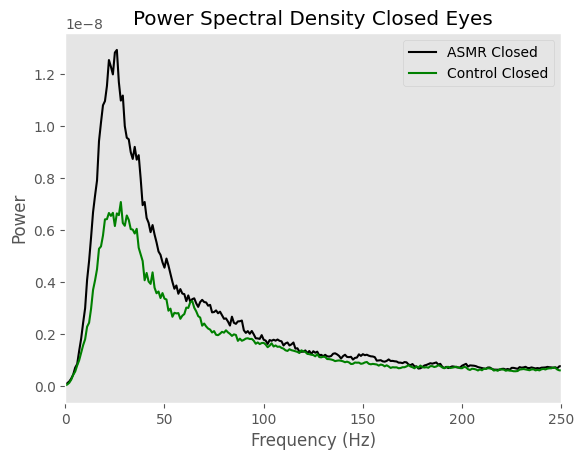

In [ ]:
#plot the data x axis is frequency y axis is power fs = 250
import matplotlib.pyplot as plt

# shape is number of subjects x number of channels x number of frequencies
# do t-test for overall frequency bands

asmr_closed_1 = np.median(np.median(asmr_closed, axis=0), axis=0)
control_closed_1 = np.median(np.median(control_closed, axis=0), axis=0)
plt.plot(asmr_closed_1, color="black")
# plt.plot(asmr_open.mean(axis=0).mean(axis=0).T)
plt.plot(control_closed_1, color="green")
# plt.plot(control_open.mean(axis=0).mean(axis=0).T)

#limit x axis to just show 250 
plt.xlim(0, 250)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")

#legend
plt.legend(["ASMR Closed", "Control Closed"])
plt.title("Power Spectral Density Closed Eyes")
# give asmr red and control blue
plt.grid()

plt.show()


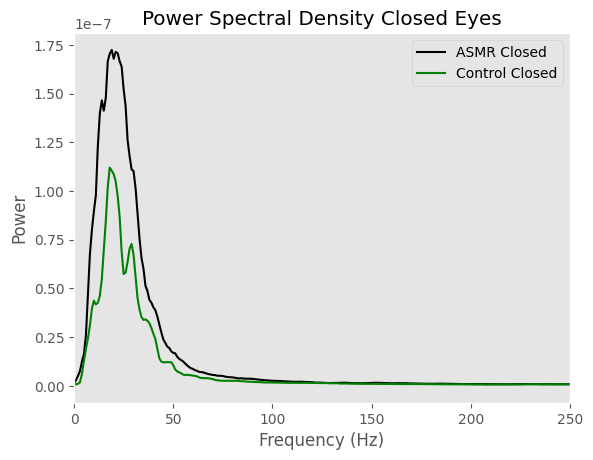

In [38]:
#plot the data x axis is frequency y axis is power fs = 250
import matplotlib.pyplot as plt

plt.plot(asmr_closed.mean(axis=0).mean(axis=0), color="black")
# plt.plot(asmr_open.mean(axis=0).mean(axis=0).T)
plt.plot(control_closed.mean(axis=0).mean(axis=0), color="green")
# plt.plot(control_open.mean(axis=0).mean(axis=0).T)

#limit x axis to just show 250 
plt.xlim(0, 250)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")

#legend
plt.legend(["ASMR Closed", "Control Closed"])
plt.title("Power Spectral Density Closed Eyes")
# give asmr red and control blue
plt.grid()

plt.show()


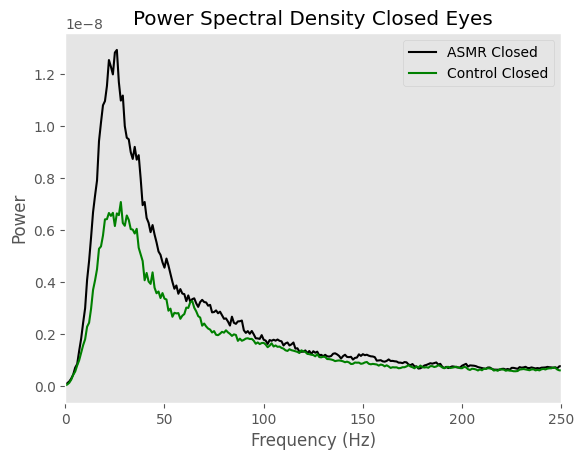

In [41]:
#plot the data x axis is frequency y axis is power fs = 250
import matplotlib.pyplot as plt

# shape is number of subjects x number of channels x number of frequencies
# do t-test for overall frequency bands

asmr_open_1 = np.median(np.median(asmr_open, axis=0), axis=0)
control_open_1 = np.median(np.median(control_open, axis=0), axis=0)
plt.plot(asmr_closed_1, color="black")
# plt.plot(asmr_open.mean(axis=0).mean(axis=0).T)
plt.plot(control_closed_1, color="green")
# plt.plot(control_open.mean(axis=0).mean(axis=0).T)

#limit x axis to just show 250 
plt.xlim(0, 250)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")

#legend
plt.legend(["ASMR Closed", "Control Closed"])
plt.title("Power Spectral Density Closed Eyes")
# give asmr red and control blue
plt.grid()

plt.show()


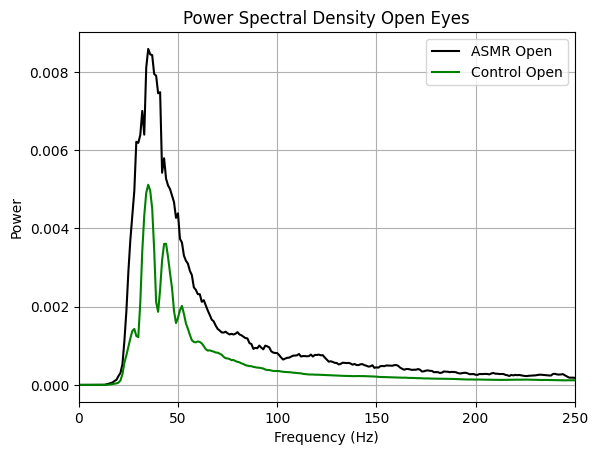

In [ ]:
#plot the data x axis is frequency y axis is power fs = 250
import matplotlib.pyplot as plt

# plt.plot(asmr_closed.mean(axis=0).mean(axis=0).T)
plt.plot(asmr_open.mean(axis=0).mean(axis=0), color="black")
# plt.plot(control_closed.mean(axis=0).mean(axis=0).T)
plt.plot(control_open.mean(axis=0).mean(axis=0), color="green")

#limit x axis to just show 250 
plt.xlim(0, 250)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")

#legend
plt.legend(["ASMR Open", "Control Open"])
plt.title("Power Spectral Density Open Eyes")
plt.grid()

plt.show()


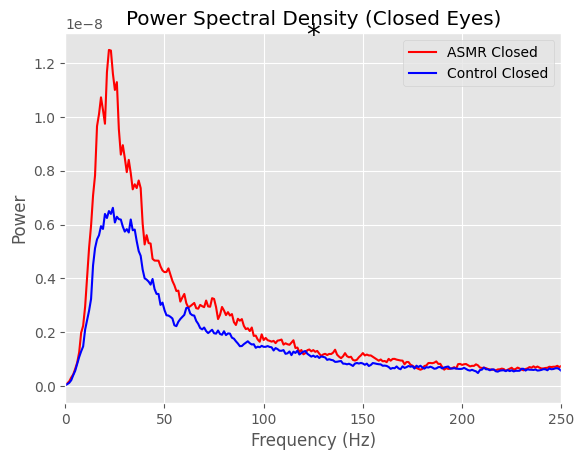

Combined t-test p-value: 0.01472833142115956


In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Assume asmr_closed and control_closed are arrays with shape:
# (n_subjects, n_channels, n_frequencies)

# 1) Collapse across channels for each subject by taking the median.
#    Resulting shape: (n_subjects, n_frequencies)
asmr_closed_subj = np.median(asmr_closed, axis=1)
control_closed_subj = np.median(control_closed, axis=1)

# 2) Compute group-level median spectra for plotting.
#    This gives one power spectrum per group (n_frequencies,).
asmr_closed_plot = np.median(asmr_closed_subj, axis=0)
control_closed_plot = np.median(control_closed_subj, axis=0)

# 3) Define the frequency range (0-250 Hz) for combining.
freq_min = 30
freq_limit = 45  # frequency index up to 250

# 4) For each subject, average the power across frequencies 0 to 250.
#    This provides one combined power value per subject.
asmr_combined = np.mean(asmr_closed_subj[:, freq_min:freq_limit+1], axis=1)
control_combined = np.mean(control_closed_subj[:, freq_min:freq_limit+1], axis=1)

# 5) Perform a single t-test on the combined values.
t_stat, p_value = ttest_ind(asmr_combined, control_combined, equal_var=False)
reject, pvals_corrected, _, _ = multipletests(p_value, alpha=0.05, method='fdr_bh')

# 6) Plot the group median spectra.
plt.plot(asmr_closed_plot, color="red", label="ASMR Closed")
plt.plot(control_closed_plot, color="blue", label="Control Closed")
plt.xlim(0, 250)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Power Spectral Density (Closed Eyes)")

# 7) If the overall p-value is significant, annotate the plot with a star.
if p_value < 0.05:
    # Here we place the star at the middle frequency (e.g., x=125) at the top of the plot.
    y_max = max(np.max(asmr_closed_plot[:251]), np.max(control_closed_plot[:251]))
    plt.text(125, y_max, '*', fontsize=20, ha='center', va='bottom')

plt.legend()
plt.grid(True)
plt.show()

print("Combined t-test p-value:", p_value)


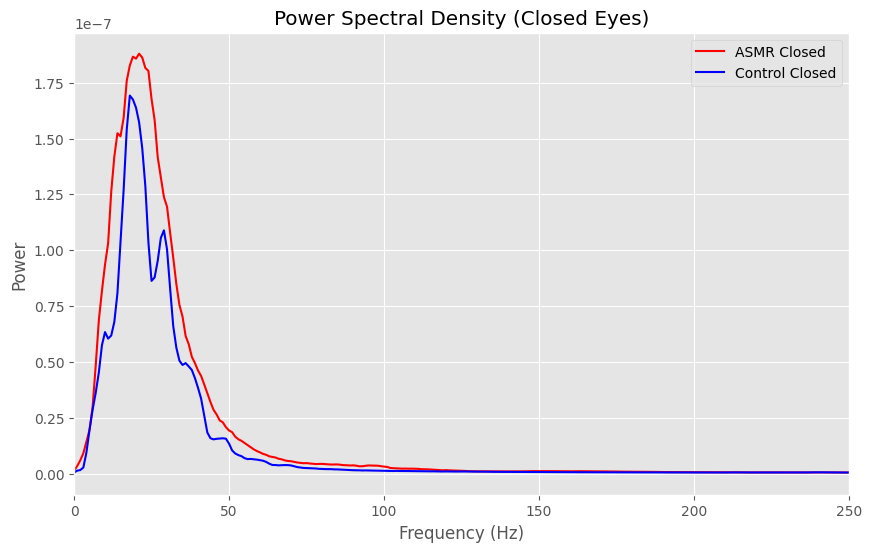

Band-specific t-test results (after FDR correction):
Delta: t-statistic = 1.209, corrected p-value = 0.967, significant: False
Theta: t-statistic = 0.042, corrected p-value = 0.967, significant: False
Alpha: t-statistic = 0.502, corrected p-value = 0.967, significant: False
Beta: t-statistic = 0.433, corrected p-value = 0.967, significant: False
Gamma: t-statistic = 0.166, corrected p-value = 0.967, significant: False


In [79]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# Assume asmr_closed and control_closed are arrays with shape:
# (n_subjects, n_channels, n_frequencies)

# asmr_closed = asmr_closed[:, central_channels_indices, :]
# control_closed = control_closed[:, central_channels_indices, :]

# 1) Collapse across channels for each subject by taking the median.
#    Resulting shape: (n_subjects, n_frequencies)
asmr_closed_subj = np.mean(asmr_closed[:, frontal_channels_indices, :], axis=1)
control_closed_subj = np.mean(control_closed[:, frontal_channels_indices, :], axis=1)

# 2) Compute group-level median spectra for plotting.
#    This gives one power spectrum per group (n_frequencies,).
asmr_closed_plot = np.mean(asmr_closed_subj, axis=0)
control_closed_plot = np.mean(control_closed_subj, axis=0)

# 3) Define frequency bands (example bands in Hz).
# You can adjust these ranges as needed.
bands = {
    'Delta': (1, 4),
    'Theta': (4, 8),
    'Alpha': (8, 12),
    'Beta': (12, 30),
    'Gamma': (30, 45)
}

# 4) For each band, average the power across the band (per subject) and perform a t-test.
band_pvals = {}
band_tstats = {}
for band, (start, end) in bands.items():
    # Compute per-subject average power for this band.
    asmr_band = np.median(asmr_closed_subj[:, start:end+1], axis=1)
    control_band = np.median(control_closed_subj[:, start:end+1], axis=1)
    
    # Perform the t-test for this frequency band.
    t_stat, p_val = ttest_ind(asmr_band, control_band, equal_var=False)
    band_tstats[band] = t_stat
    band_pvals[band] = p_val

# 5) Apply multiple-comparison correction (FDR/BH) across the bands.
band_names = list(band_pvals.keys())
pvals_array = np.array([band_pvals[band] for band in band_names])
rejects, pvals_corrected, _, _ = multipletests(pvals_array, alpha=0.05, method='fdr_bh')

# Map the results back to each band.
band_significance = {band_names[i]: (rejects[i], pvals_corrected[i]) for i in range(len(band_names))}

# 6) Plot the group median power spectra.
plt.figure(figsize=(10, 6))
plt.plot(asmr_closed_plot, color="red", label="ASMR Closed")
plt.plot(control_closed_plot, color="blue", label="Control Closed")
plt.xlim(0, 250)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Power Spectral Density (Closed Eyes)")

# 7) Annotate the plot with an asterisk (*) for each significant frequency band.
for band, (start, end) in bands.items():
    is_sig, p_corr = band_significance[band]
    if is_sig:
        # Place the star at the center of the band.
        center = (start + end) / 2
        # Get the maximum power value in the band from both group median curves.
        y_band_max = max(np.max(asmr_closed_plot[start:end+1]),
                         np.max(control_closed_plot[start:end+1]))
        # Add an offset for the asterisk (e.g., 5% above the maximum).
        y_offset = y_band_max * 0.05
        plt.text(center, y_band_max + y_offset, '*', fontsize=20, ha='center', va='bottom')

plt.legend()
plt.grid(True)
plt.show()

# 8) Print the band-specific t-test results.
print("Band-specific t-test results (after FDR correction):")
for band in bands:
    is_sig, p_corr = band_significance[band]
    print(f"{band}: t-statistic = {band_tstats[band]:.3f}, corrected p-value = {p_corr:.3f}, significant: {is_sig}")


In [ ]:
#central gamma
#parietal gamma


In [58]:
import os 
import mne 
import numpy as np 

asmr_files = os.listdir("./asmr_epochs/")
print(asmr_files)
control_files = os.listdir("./control_epochs/")
print(control_files)

asmr_closed = []
asmr_open = []

control_closed = []
control_open = []

fmin = 0.5
fmax = 4

for file in asmr_files:
    epochs = mne.read_epochs("./asmr_epochs/" + file, verbose=0)
    epochs.drop_channels(["HOEG", "VEOG"])
    asmr_closed.append(epochs["Closed Eyes"].compute_psd(fmin = fmin, fmax = fmax).average())
    # print(epochs["Closed Eyes"].compute_psd().get_data().mean(axis=0).shape)
    asmr_open.append(epochs["Open Eyes"].compute_psd(fmin = fmin, fmax = fmax).average())

for file in control_files:

    epochs = mne.read_epochs("./control_epochs/" + file, verbose=0)
    epochs.drop_channels(["HOEG", "VEOG"])

    control_closed.append(epochs["Closed Eyes"].compute_psd(fmin = fmin, fmax = fmax).average())
    
    control_open.append(epochs["Open Eyes"].compute_psd(fmin = fmin, fmax = fmax).average())
    



['16-epochs-epo.fif', '8-epochs-epo.fif', '10-epochs-epo.fif', '1-epochs-epo.fif', '11-epochs-epo.fif', '9-epochs-epo.fif', '14-epochs-epo.fif', '12-epochs-epo.fif', '13-epochs-epo.fif', '2-epochs-epo.fif', '6-epochs-epo.fif', '7-epochs-epo.fif', '15-epochs-epo.fif', '5-epochs-epo.fif', '3-epochs-epo.fif', '4-epochs-epo.fif']
['8-epochs-epo.fif', '10-epochs-epo.fif', '1-epochs-epo.fif', '11-epochs-epo.fif', '9-epochs-epo.fif', '14-epochs-epo.fif', '12-epochs-epo.fif', '13-epochs-epo.fif', '2-epochs-epo.fif', '6-epochs-epo.fif', '7-epochs-epo.fif', '15-epochs-epo.fif', '5-epochs-epo.fif', '3-epochs-epo.fif', '4-epochs-epo.fif']
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows

(31,)


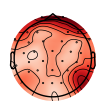

(31,)


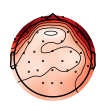

(31,)


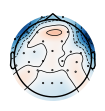

(<matplotlib.image.AxesImage at 0x778f96ace0b0>,
 <matplotlib.contour.QuadContourSet at 0x778f95078550>)

In [63]:
asmr_closed_psd = []

for i in range(len(asmr_closed)):
    asmr_closed_psd.append(asmr_closed[i].get_data().mean(axis=1))

asmr_closed_psd = np.array(asmr_closed_psd).mean(axis=0)
print(asmr_closed_psd.shape)
mne.viz.plot_topomap(asmr_closed_psd, epochs.info, show=True)


control_closed_psd = []

for i in range(len(control_closed)):
    control_closed_psd.append(control_closed[i].get_data().mean(axis=1))

control_closed_psd = np.array(control_closed_psd).mean(axis=0)
print(control_closed_psd.shape)
mne.viz.plot_topomap(control_closed_psd, epochs.info, show=True)



difference = asmr_closed_psd - control_closed_psd
print(difference.shape)

mne.viz.plot_topomap(difference, epochs.info, show=True)

In [8]:
import os
import numpy as np
import mne
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# Higuchi’s Fractal Dimension function
from hfd import hfd  # Make sure you have installed/imported your HFD function

###############################################################################
#                     (A) User Parameters & Frequency Bands                   #
###############################################################################
# Define your frequency bands (you can modify or add more)
freq_bands = {
    "Delta": (0.5, 4),
    "Theta": (4, 8),
    "Alpha": (8, 12),
    "Beta":  (12, 30),
    "Gamma": (30, 45)
}

# Define scalp region indices (adjust if your channel naming differs)
# We'll fill these after we read at least one epochs file to get ch_names.
region_indices = {}

###############################################################################
#                         (B) Read File Names                                 #
###############################################################################
asmr_files = os.listdir("./asmr_epochs/")
control_files = os.listdir("./control_epochs/")

print("ASMR files found:", asmr_files)
print("Control files found:", control_files)

# Helper function to read all files in a folder, drop EOG channels, filter for a band,
# and extract "Open Eyes" and "Closed Eyes" data as numpy arrays.
def load_and_filter_epochs(folder_path, files_list, fmin, fmax):
    """
    Reads each file in files_list from folder_path, drops EOG channels,
    filters between (fmin, fmax), and returns:
      closed_data: (n_subjects, n_epochs, n_channels, n_times)
      open_data:   (n_subjects, n_epochs, n_channels, n_times)
    """
    closed_all = []
    open_all = []
    for filename in files_list:
        full_path = os.path.join(folder_path, filename)
        epochs = mne.read_epochs(full_path, verbose=False)
        # Drop EOG channels if present
        for eog_ch in ["HOEG", "VEOG"]:
            if eog_ch in epochs.ch_names:
                epochs.drop_channels([eog_ch], on_missing='ignore')
        # Filter
        epochs = epochs.filter(fmin, fmax, verbose=False)
        # Append data
        closed_all.append(epochs["Closed Eyes"])
        open_all.append(epochs["Open Eyes"])
    return closed_all, open_all, epochs.ch_names  # Return ch_names from the last file

###############################################################################
#            (C) Prepare to Collect All T-tests & P-values (for FDR)          #
###############################################################################
all_results = []   # Will store dicts with info about each test
all_pvals   = []   # Will store uncorrected p-values for FDR correction

###############################################################################
#                (D) Loop Over Each Frequency Band & Analyze                  #
###############################################################################
for band_name, (fmin, fmax) in freq_bands.items():
    print(f"\n===== Analyzing band: {band_name} ({fmin}–{fmax} Hz) =====")

    # 1) Load and filter data for this band
    asmr_closed_all, asmr_open_all, ch_names = load_and_filter_epochs(
        "./asmr_epochs", asmr_files, fmin, fmax
    )
    control_closed_all, control_open_all, _   = load_and_filter_epochs(
        "./control_epochs", control_files, fmin, fmax
    )

    # If you want to limit to first N subjects, do so here:
    N = 10
    asmr_closed_all   = asmr_closed_all[:N]
    asmr_open_all     = asmr_open_all[:N]
    control_closed_all = control_closed_all[:N]
    control_open_all   = control_open_all[:N]

    # Print shapes for sanity check
    # print(f"  ASMR closed shape:   {asmr_closed_all.shape}")
    # print(f"  ASMR open shape:     {asmr_open_all.shape}")
    # print(f"  Control closed shape:{control_closed_all.shape}")
    # print(f"  Control open shape:  {control_open_all.shape}")

    # 2) If region_indices is empty (first band we load), fill it now
    if not region_indices:
        occipital_channels_indices = [i for i, ch in enumerate(ch_names) if ch.startswith("O")]
        parietal_channels_indices  = [i for i, ch in enumerate(ch_names) if ch.startswith("P")]
        temporal_channels_indices  = [i for i, ch in enumerate(ch_names) if ch.startswith("T")]
        frontal_channels_indices   = [i for i, ch in enumerate(ch_names) if ch.startswith("F")]
        central_channels_indices   = [i for i, ch in enumerate(ch_names) if ch.startswith("C")]

        region_indices = {
            "Occipital": occipital_channels_indices,
            "Parietal":  parietal_channels_indices,
            "Temporal":  temporal_channels_indices,
            "Frontal":   frontal_channels_indices,
            "Central":   central_channels_indices
        }

    # 3) Loop over each region
    for region_name, region_chs in region_indices.items():
        print(f"  -> Region: {region_name} (channels: {region_chs})")

        # Extract region channels from each array
        # shape is (n_subjects, n_epochs, n_channels, n_times)
        asmr_cl_reg = mne.concatenate_epochs(asmr_closed_all)
        asmr_op_reg = mne.concatenate_epochs(asmr_open_all)
        ctrl_cl_reg = mne.concatenate_epochs(control_closed_all)
        ctrl_op_reg = mne.concatenate_epochs(control_open_all)
        
        def compute_avg_psd(data_mne_epochs):
            #use scipy and numpy for psd
            psd_values = []
            for i in range(len(data_mne_epochs)):
                psd_values.append(data_mne_epochs[i].compute_psd(verbose = 0).get_data()[:, region_chs, :].mean(axis=1)) # epochs, channels, freq
                
            return np.array(psd_values).mean(axis=2) # average across frequency bins
        
        asmr_cl_hfd = compute_avg_psd(asmr_cl_reg)
        asmr_op_hfd = compute_avg_psd(asmr_op_reg)
        ctrl_cl_hfd = compute_avg_psd(ctrl_cl_reg)
        ctrl_op_hfd = compute_avg_psd(ctrl_op_reg)


        
           

        # 5) Perform two t-tests: Closed and Open
        #    a) Closed
        t_stat_cl, p_val_cl = ttest_ind(asmr_cl_hfd, ctrl_cl_hfd, equal_var=True)
        all_results.append({
            "Band": band_name,
            "Region": region_name,
            "Condition": "Closed",
            "p_uncorrected": p_val_cl,
            "ASMR_values": asmr_cl_hfd,
            "Control_values": ctrl_cl_hfd
        })
        all_pvals.append(p_val_cl)

        #    b) Open
        t_stat_op, p_val_op = ttest_ind(asmr_op_hfd, ctrl_op_hfd, equal_var=True)
        all_results.append({
            "Band": band_name,
            "Region": region_name,
            "Condition": "Open",
            "p_uncorrected": p_val_op,
            "ASMR_values": asmr_op_hfd,
            "Control_values": ctrl_op_hfd
        })
        all_pvals.append(p_val_op)

###############################################################################
#       (E) FDR-correct all p-values across all bands × regions × conditions  #
###############################################################################
print(f"\nTotal number of t-tests: {len(all_pvals)}")
reject_flags, pvals_corrected, _, _ = multipletests(all_pvals, method='fdr_bh')

# Insert corrected p-values & significance into all_results
for i, (res_dict, p_corr, reject) in enumerate(zip(all_results, pvals_corrected, reject_flags)):
    res_dict["p_corrected"] = p_corr
    res_dict["Significant"] = reject

###############################################################################
#        (F) Boxplot function to visualize significant comparisons            #
###############################################################################
def plot_boxplot(asmr_values, ctrl_values, title, p_corr, filename):
    """
    Plots a boxplot comparing two groups (ASMR vs. Control) with a significance line.
    """
    fig, ax = plt.subplots(figsize=(6, 6))

    # Create the boxplot
    bp = ax.boxplot([asmr_values, ctrl_values],
                    positions=[1, 2],
                    patch_artist=True,
                    showmeans=True,
                    widths=0.7)

    # Optional color fill
    colors = ['orange', 'green']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    # Jittered data points
    for i, d in enumerate([asmr_values, ctrl_values]):
        x_jitter = np.random.normal(1 + i, 0.04, size=len(d))
        ax.scatter(x_jitter, d, color="black", alpha=0.7)

    ax.set_xticks([1, 2])
    ax.set_xticklabels(["ASMR", "Control"], fontsize=14, color="black")
    ax.set_ylabel("HFD", fontsize=14, color="black")
    ax.set_title(title, fontsize=16, color="black")
    ax.grid(True)

    # Significance annotation
    max_val = max(np.max(asmr_values), np.max(ctrl_values))
    y_base = max_val + 0.05 * max_val
    y_top = y_base + 0.05 * max_val

    # Decide on star annotation
    if p_corr < 0.001:
        sig_text = '***'
    elif p_corr < 0.05:
        sig_text = '**'
    elif p_corr < 0.1:
        sig_text = '*'
    else:
        sig_text = ''

    if sig_text != '':
        ax.plot([1, 1, 2, 2], [y_base, y_top, y_top, y_base], lw=1.5, color='black')
        ax.text(1.5, y_top, sig_text, ha='center', va='bottom', fontsize=16, color='black')

    plt.tight_layout()
    os.makedirs("plots", exist_ok=True)
    plt.savefig(filename, dpi=300)
    plt.close()

###############################################################################
# (G) Plot only the comparisons with p_corrected < 0.1, and store them in CSV
###############################################################################
significant_results = []
for res in all_results:
    if res["p_corrected"] < 0.1:
        # Construct a safe filename
        cond_str = "Closed" if res["Condition"] == "Closed" else "Open"
        band_str = res["Band"].replace(" ", "_")
        region_str = res["Region"].replace(" ", "_")
        fname = f"plots/{cond_str}_Eyes_{band_str}_{region_str}_HFD.png"

        # Title for the plot
        title_str = (f"{res['Region']} | {res['Band']} band | {res['Condition']} Eyes\n"
                     f"p_corr = {res['p_corrected']:.3f}")

        plot_boxplot(res["ASMR_values"], res["Control_values"], title_str, res["p_corrected"], fname)

        # Also collect in a final list
        significant_results.append({
            "Band":       res["Band"],
            "Region":     res["Region"],
            "Condition":  res["Condition"],
            "p_uncorrected": res["p_uncorrected"],
            "p_corrected":   res["p_corrected"],
            "Significant":   True
        })

# Save significant results to CSV
df_sig = pd.DataFrame(significant_results)
df_sig.to_csv("plots/significant_pvalues.csv", index=False)
print("\nSignificant results saved to 'plots/significant_pvalues.csv'")
print("Done!")


ASMR files found: ['16-epochs-epo.fif', '8-epochs-epo.fif', '10-epochs-epo.fif', '1-epochs-epo.fif', '11-epochs-epo.fif', '9-epochs-epo.fif', '14-epochs-epo.fif', '12-epochs-epo.fif', '13-epochs-epo.fif', '2-epochs-epo.fif', '6-epochs-epo.fif', '7-epochs-epo.fif', '15-epochs-epo.fif', '5-epochs-epo.fif', '3-epochs-epo.fif', '4-epochs-epo.fif']
Control files found: ['8-epochs-epo.fif', '10-epochs-epo.fif', '1-epochs-epo.fif', '11-epochs-epo.fif', '9-epochs-epo.fif', '14-epochs-epo.fif', '12-epochs-epo.fif', '13-epochs-epo.fif', '2-epochs-epo.fif', '6-epochs-epo.fif', '7-epochs-epo.fif', '15-epochs-epo.fif', '5-epochs-epo.fif', '3-epochs-epo.fif', '4-epochs-epo.fif']

===== Analyzing band: Delta (0.5–4 Hz) =====
  -> Region: Occipital (channels: [14, 15])
Not setting metadata
30 matching events found
No baseline correction applied
Not setting metadata
30 matching events found
No baseline correction applied
Not setting metadata
30 matching events found
No baseline correction applied
Not s

/tmp/ipykernel_3576028/4261195626.py:117: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  asmr_cl_reg = mne.concatenate_epochs(asmr_closed_all)
/tmp/ipykernel_3576028/4261195626.py:118: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  asmr_op_reg = mne.concatenate_epochs(asmr_open_all)
/tmp/ipykernel_3576028/4261195626.py:119: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ctrl_cl_reg = mne.concatenate_epochs(control_closed_all)
/tmp/ipykernel_3576028/4261195626.py:120: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ctrl_op_reg = mne.concatenate_epochs(control_open_all)


  -> Region: Parietal (channels: [11, 12, 13, 16, 17])
Not setting metadata
30 matching events found
No baseline correction applied
Not setting metadata
30 matching events found
No baseline correction applied
Not setting metadata
30 matching events found
No baseline correction applied
Not setting metadata
30 matching events found
No baseline correction applied


/tmp/ipykernel_3576028/4261195626.py:117: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  asmr_cl_reg = mne.concatenate_epochs(asmr_closed_all)
/tmp/ipykernel_3576028/4261195626.py:118: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  asmr_op_reg = mne.concatenate_epochs(asmr_open_all)
/tmp/ipykernel_3576028/4261195626.py:119: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ctrl_cl_reg = mne.concatenate_epochs(control_closed_all)
/tmp/ipykernel_3576028/4261195626.py:120: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ctrl_op_reg = mne.concatenate_epochs(control_open_all)


  -> Region: Temporal (channels: [7, 8, 18, 23])
Not setting metadata
30 matching events found
No baseline correction applied
Not setting metadata
30 matching events found
No baseline correction applied
Not setting metadata
30 matching events found
No baseline correction applied
Not setting metadata
30 matching events found
No baseline correction applied


/tmp/ipykernel_3576028/4261195626.py:117: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  asmr_cl_reg = mne.concatenate_epochs(asmr_closed_all)
/tmp/ipykernel_3576028/4261195626.py:118: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  asmr_op_reg = mne.concatenate_epochs(asmr_open_all)
/tmp/ipykernel_3576028/4261195626.py:119: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ctrl_cl_reg = mne.concatenate_epochs(control_closed_all)
/tmp/ipykernel_3576028/4261195626.py:120: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ctrl_op_reg = mne.concatenate_epochs(control_open_all)


  -> Region: Frontal (channels: [0, 1, 2, 3, 4, 5, 24, 25, 26, 27, 28, 29])
Not setting metadata
30 matching events found
No baseline correction applied
Not setting metadata
30 matching events found
No baseline correction applied
Not setting metadata
30 matching events found
No baseline correction applied
Not setting metadata
30 matching events found
No baseline correction applied


/tmp/ipykernel_3576028/4261195626.py:117: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  asmr_cl_reg = mne.concatenate_epochs(asmr_closed_all)
/tmp/ipykernel_3576028/4261195626.py:118: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  asmr_op_reg = mne.concatenate_epochs(asmr_open_all)
/tmp/ipykernel_3576028/4261195626.py:119: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ctrl_cl_reg = mne.concatenate_epochs(control_closed_all)
/tmp/ipykernel_3576028/4261195626.py:120: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ctrl_op_reg = mne.concatenate_epochs(control_open_all)


  -> Region: Central (channels: [6, 9, 10, 19, 20, 21, 22])
Not setting metadata
30 matching events found
No baseline correction applied
Not setting metadata
30 matching events found
No baseline correction applied
Not setting metadata
30 matching events found
No baseline correction applied
Not setting metadata
30 matching events found
No baseline correction applied


/tmp/ipykernel_3576028/4261195626.py:117: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  asmr_cl_reg = mne.concatenate_epochs(asmr_closed_all)
/tmp/ipykernel_3576028/4261195626.py:118: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  asmr_op_reg = mne.concatenate_epochs(asmr_open_all)
/tmp/ipykernel_3576028/4261195626.py:119: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ctrl_cl_reg = mne.concatenate_epochs(control_closed_all)
/tmp/ipykernel_3576028/4261195626.py:120: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ctrl_op_reg = mne.concatenate_epochs(control_open_all)



===== Analyzing band: Theta (4–8 Hz) =====
  -> Region: Occipital (channels: [14, 15])
Not setting metadata
30 matching events found
No baseline correction applied
Not setting metadata
30 matching events found
No baseline correction applied
Not setting metadata
30 matching events found
No baseline correction applied
Not setting metadata
30 matching events found
No baseline correction applied


/tmp/ipykernel_3576028/4261195626.py:117: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  asmr_cl_reg = mne.concatenate_epochs(asmr_closed_all)
/tmp/ipykernel_3576028/4261195626.py:118: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  asmr_op_reg = mne.concatenate_epochs(asmr_open_all)
/tmp/ipykernel_3576028/4261195626.py:119: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ctrl_cl_reg = mne.concatenate_epochs(control_closed_all)
/tmp/ipykernel_3576028/4261195626.py:120: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ctrl_op_reg = mne.concatenate_epochs(control_open_all)


KeyboardInterrupt: 

In [7]:
import os
import numpy as np
import mne
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# Higuchi’s Fractal Dimension function
from hfd import hfd  # Make sure you have installed/imported your HFD function

###############################################################################
#                     (A) User Parameters & Frequency Bands                   #
###############################################################################
freq_bands = {
    "Delta": (0.5, 4),
    "Theta": (4, 8),
    "Alpha": (8, 12),
    "Beta":  (12, 30),
    "Gamma": (30, 45)
}

region_indices = {}

###############################################################################
#                         (B) Read File Names                                 #
###############################################################################
asmr_files = os.listdir("./asmr_epochs/")
control_files = os.listdir("./control_epochs/")

print("ASMR files found:", asmr_files)
print("Control files found:", control_files)

def load_and_filter_epochs(folder_path, files_list, fmin, fmax):
    closed_all = []
    open_all = []
    for filename in files_list:
        full_path = os.path.join(folder_path, filename)
        epochs = mne.read_epochs(full_path, verbose=False)
        for eog_ch in ["HOEG", "VEOG"]:
            if eog_ch in epochs.ch_names:
                epochs.drop_channels([eog_ch], on_missing='ignore')
        epochs = epochs.filter(fmin, fmax, verbose=False)
        closed_all.append(epochs["Closed Eyes"])
        open_all.append(epochs["Open Eyes"])
    return closed_all, open_all, epochs.ch_names

###############################################################################
#            (C) Prepare to Collect All T-tests & P-values (for FDR)          #
###############################################################################
all_results = []
all_pvals   = []

###############################################################################
#                (D) Loop Over Each Frequency Band & Analyze                  #
###############################################################################
for band_name, (fmin, fmax) in freq_bands.items():
    print(f"\n===== Analyzing band: {band_name} ({fmin}–{fmax} Hz) =====")

    asmr_closed_all, asmr_open_all, ch_names = load_and_filter_epochs(
        "./asmr_epochs", asmr_files, fmin, fmax
    )
    control_closed_all, control_open_all, _ = load_and_filter_epochs(
        "./control_epochs", control_files, fmin, fmax
    )

    N = 10
    asmr_closed_all = asmr_closed_all[:N]
    asmr_open_all = asmr_open_all[:N]
    control_closed_all = control_closed_all[:N]
    control_open_all = control_open_all[:N]

    if not region_indices:
        occipital = [i for i, ch in enumerate(ch_names) if ch.startswith("O")]
        parietal  = [i for i, ch in enumerate(ch_names) if ch.startswith("P")]
        temporal  = [i for i, ch in enumerate(ch_names) if ch.startswith("T")]
        frontal   = [i for i, ch in enumerate(ch_names) if ch.startswith("F")]
        central   = [i for i, ch in enumerate(ch_names) if ch.startswith("C")]
        region_indices = {
            "Occipital": occipital,
            "Parietal":  parietal,
            "Temporal":  temporal,
            "Frontal":   frontal,
            "Central":   central
        }

    for region_name, region_chs in region_indices.items():
        print(f"  -> Region: {region_name} (channels: {region_chs})")

        asmr_cl_reg = mne.concatenate_epochs(asmr_closed_all)
        asmr_op_reg = mne.concatenate_epochs(asmr_open_all)
        ctrl_cl_reg = mne.concatenate_epochs(control_closed_all)
        ctrl_op_reg = mne.concatenate_epochs(control_open_all)
        
        def compute_avg_psd(data_mne_epochs):
            psd_values = []
            for i in range(len(data_mne_epochs)):
                psd = data_mne_epochs[i].compute_psd(verbose=0).get_data()[:, region_chs, :]
                # Average across channels and frequency bins
                psd_values.append(psd.mean(axis=(1, 2)))
            return np.array(psd_values).flatten()
        
        asmr_cl_hfd = compute_avg_psd(asmr_cl_reg)
        asmr_op_hfd = compute_avg_psd(asmr_op_reg)
        ctrl_cl_hfd = compute_avg_psd(ctrl_cl_reg)
        ctrl_op_hfd = compute_avg_psd(ctrl_op_reg)

        # Function to compute degrees of freedom for Welch's t-test
        def compute_degrees_of_freedom(sample1, sample2):
            n1 = len(sample1)
            n2 = len(sample2)
            var1 = np.var(sample1, ddof=1)
            var2 = np.var(sample2, ddof=1)
            numerator = (var1/n1 + var2/n2)**2
            denominator = ((var1/n1)**2 / (n1-1)) + ((var2/n2)**2 / (n2-1))
            return numerator / denominator

        # a) Closed Eyes
        t_stat_cl, p_val_cl = ttest_ind(asmr_cl_hfd, ctrl_cl_hfd, equal_var=False)
        df_cl = compute_degrees_of_freedom(asmr_cl_hfd, ctrl_cl_hfd)
        all_results.append({
            "Band": band_name,
            "Region": region_name,
            "Condition": "Closed",
            "t_stat": t_stat_cl,
            "df": df_cl,
            "p_uncorrected": p_val_cl,
            "ASMR_values": asmr_cl_hfd,
            "Control_values": ctrl_cl_hfd
        })
        all_pvals.append(p_val_cl)

        # b) Open Eyes
        t_stat_op, p_val_op = ttest_ind(asmr_op_hfd, ctrl_op_hfd, equal_var=False)
        df_op = compute_degrees_of_freedom(asmr_op_hfd, ctrl_op_hfd)
        all_results.append({
            "Band": band_name,
            "Region": region_name,
            "Condition": "Open",
            "t_stat": t_stat_op,
            "df": df_op,
            "p_uncorrected": p_val_op,
            "ASMR_values": asmr_op_hfd,
            "Control_values": ctrl_op_hfd
        })
        all_pvals.append(p_val_op)

###############################################################################
#       (E) FDR-correct all p-values across all bands × regions × conditions  #
###############################################################################
print(f"\nTotal number of t-tests: {len(all_pvals)}")
reject_flags, pvals_corrected, _, _ = multipletests(all_pvals, method='fdr_bh')

for i, (res_dict, p_corr, reject) in enumerate(zip(all_results, pvals_corrected, reject_flags)):
    res_dict["p_corrected"] = p_corr
    res_dict["Significant"] = reject

###############################################################################
#        (F) Boxplot function to visualize significant comparisons            #
###############################################################################
def plot_boxplot(asmr_values, ctrl_values, title, p_corr, filename):
    fig, ax = plt.subplots(figsize=(6, 6))
    bp = ax.boxplot([asmr_values, ctrl_values],
                    positions=[1, 2],
                    patch_artist=True,
                    showmeans=True,
                    widths=0.7)
    colors = ['orange', 'green']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    for i, d in enumerate([asmr_values, ctrl_values]):
        x_jitter = np.random.normal(1 + i, 0.04, size=len(d))
        ax.scatter(x_jitter, d, color="black", alpha=0.7)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(["ASMR", "Control"], fontsize=14, color="black")
    ax.set_ylabel("HFD", fontsize=14, color="black")
    ax.set_title(title, fontsize=16, color="black")
    ax.grid(True)
    max_val = max(np.max(asmr_values), np.max(ctrl_values))
    y_base = max_val + 0.05 * max_val
    y_top = y_base + 0.05 * max_val
    if p_corr < 0.001:
        sig_text = '***'
    elif p_corr < 0.05:
        sig_text = '**'
    elif p_corr < 0.1:
        sig_text = '*'
    else:
        sig_text = ''
    if sig_text != '':
        ax.plot([1, 1, 2, 2], [y_base, y_top, y_top, y_base], lw=1.5, color='black')
        ax.text(1.5, y_top, sig_text, ha='center', va='bottom', fontsize=16, color='black')
    plt.tight_layout()
    os.makedirs("plots", exist_ok=True)
    plt.savefig(filename, dpi=300)
    plt.close()

###############################################################################
# (G) Plot only the comparisons with p_corrected < 0.1, and store them in CSV
###############################################################################
significant_results = []
for res in all_results:
    if res["p_corrected"] < 0.1:
        cond_str = "Closed" if res["Condition"] == "Closed" else "Open"
        band_str = res["Band"].replace(" ", "_")
        region_str = res["Region"].replace(" ", "_")
        fname = f"plots/{cond_str}_Eyes_{band_str}_{region_str}_HFD.png"
        title_str = (f"{res['Region']} | {res['Band']} band | {res['Condition']} Eyes\n"
                     f"t = {res['t_stat']:.2f}, df = {res['df']:.1f}, p_corr = {res['p_corrected']:.3f}")
        plot_boxplot(res["ASMR_values"], res["Control_values"], title_str, res["p_corrected"], fname)
        significant_results.append({
            "Band": res["Band"],
            "Region": res["Region"],
            "Condition": res["Condition"],
            "t_stat": res["t_stat"],
            "df": res["df"],
            "p_uncorrected": res["p_uncorrected"],
            "p_corrected": res["p_corrected"],
            "Significant": True
        })

df_sig = pd.DataFrame(significant_results)
df_sig.to_csv("plots/significant_pvalues.csv", index=False)
print("\nSignificant results saved to 'plots/significant_pvalues.csv'")
print("Done!")


ASMR files found: ['16-epochs-epo.fif', '8-epochs-epo.fif', '10-epochs-epo.fif', '1-epochs-epo.fif', '11-epochs-epo.fif', '9-epochs-epo.fif', '14-epochs-epo.fif', '12-epochs-epo.fif', '13-epochs-epo.fif', '2-epochs-epo.fif', '6-epochs-epo.fif', '7-epochs-epo.fif', '15-epochs-epo.fif', '5-epochs-epo.fif', '3-epochs-epo.fif', '4-epochs-epo.fif']
Control files found: ['8-epochs-epo.fif', '10-epochs-epo.fif', '1-epochs-epo.fif', '11-epochs-epo.fif', '9-epochs-epo.fif', '14-epochs-epo.fif', '12-epochs-epo.fif', '13-epochs-epo.fif', '2-epochs-epo.fif', '6-epochs-epo.fif', '7-epochs-epo.fif', '15-epochs-epo.fif', '5-epochs-epo.fif', '3-epochs-epo.fif', '4-epochs-epo.fif']

===== Analyzing band: Delta (0.5–4 Hz) =====
  -> Region: Occipital (channels: [14, 15])
Not setting metadata
30 matching events found
No baseline correction applied
Not setting metadata
30 matching events found
No baseline correction applied
Not setting metadata
30 matching events found
No baseline correction applied
Not s

/tmp/ipykernel_3576028/1810287008.py:90: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  asmr_cl_reg = mne.concatenate_epochs(asmr_closed_all)
/tmp/ipykernel_3576028/1810287008.py:91: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  asmr_op_reg = mne.concatenate_epochs(asmr_open_all)
/tmp/ipykernel_3576028/1810287008.py:92: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ctrl_cl_reg = mne.concatenate_epochs(control_closed_all)
/tmp/ipykernel_3576028/1810287008.py:93: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ctrl_op_reg = mne.concatenate_epochs(control_open_all)


  -> Region: Parietal (channels: [11, 12, 13, 16, 17])
Not setting metadata
30 matching events found
No baseline correction applied
Not setting metadata
30 matching events found
No baseline correction applied
Not setting metadata
30 matching events found
No baseline correction applied
Not setting metadata
30 matching events found
No baseline correction applied


/tmp/ipykernel_3576028/1810287008.py:90: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  asmr_cl_reg = mne.concatenate_epochs(asmr_closed_all)
/tmp/ipykernel_3576028/1810287008.py:91: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  asmr_op_reg = mne.concatenate_epochs(asmr_open_all)
/tmp/ipykernel_3576028/1810287008.py:92: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ctrl_cl_reg = mne.concatenate_epochs(control_closed_all)
/tmp/ipykernel_3576028/1810287008.py:93: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ctrl_op_reg = mne.concatenate_epochs(control_open_all)


  -> Region: Temporal (channels: [7, 8, 18, 23])
Not setting metadata
30 matching events found
No baseline correction applied
Not setting metadata
30 matching events found
No baseline correction applied
Not setting metadata
30 matching events found
No baseline correction applied
Not setting metadata
30 matching events found
No baseline correction applied


/tmp/ipykernel_3576028/1810287008.py:90: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  asmr_cl_reg = mne.concatenate_epochs(asmr_closed_all)
/tmp/ipykernel_3576028/1810287008.py:91: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  asmr_op_reg = mne.concatenate_epochs(asmr_open_all)
/tmp/ipykernel_3576028/1810287008.py:92: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ctrl_cl_reg = mne.concatenate_epochs(control_closed_all)
/tmp/ipykernel_3576028/1810287008.py:93: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ctrl_op_reg = mne.concatenate_epochs(control_open_all)


  -> Region: Frontal (channels: [0, 1, 2, 3, 4, 5, 24, 25, 26, 27, 28, 29])
Not setting metadata
30 matching events found
No baseline correction applied
Not setting metadata
30 matching events found
No baseline correction applied
Not setting metadata
30 matching events found
No baseline correction applied
Not setting metadata
30 matching events found
No baseline correction applied


/tmp/ipykernel_3576028/1810287008.py:90: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  asmr_cl_reg = mne.concatenate_epochs(asmr_closed_all)
/tmp/ipykernel_3576028/1810287008.py:91: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  asmr_op_reg = mne.concatenate_epochs(asmr_open_all)
/tmp/ipykernel_3576028/1810287008.py:92: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ctrl_cl_reg = mne.concatenate_epochs(control_closed_all)
/tmp/ipykernel_3576028/1810287008.py:93: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  ctrl_op_reg = mne.concatenate_epochs(control_open_all)


KeyboardInterrupt: 